# Step 1: Setting Up the Environment

In [ ]:
print("Hello, PySpark!")

Hello, PySpark!


# Step 2: Loading and Exploring the Data


In [ ]:
# Load full trip data and fare data from Blob Storage
trip_df = spark.read.option("header", "true").csv(
    "wasbs://nyc-taxi@nyctaxiblob1994.blob.core.windows.net/trip_data.csv"
)
fare_df = spark.read.option("header", "true").csv(
    "wasbs://nyc-taxi@nyctaxiblob1994.blob.core.windows.net/trip_fare.csv"
)

trip_df.printSchema()
fare_df.printSchema()



root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_time_in_secs: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)

root
 |-- medallion: string (nullable = true)
 |--  hack_license: string (nullable = true)
 |--  vendor_id: string (nullable = true)
 |--  pickup_datetime: string (nullable = true)
 |--  payment_type: string (nullable = true)
 |--  fare_amount: string (nullable = true)
 |--  surcharge: string (nullable = true)
 |--  mta_tax: string (nullable = tru

In [ ]:
# Print top 5 rows to understand data
trip_df.show(5)
fare_df.show(5)


+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N|2013-01-01 15:11:48|2013-01-01 15:18:10|              4|              382|         1.00|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...| 

In [ ]:
from pyspark.sql.functions import col, isnan, count, when
trip_df.select([count(when(col(c).isNull(), c)).alias(c) for c in trip_df.columns]).show()


+---------+------------+---------+---------+------------------+---------------+----------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|medallion|hack_license|vendor_id|rate_code|store_and_fwd_flag|pickup_datetime|dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+---------+------------+---------+---------+------------------+---------------+----------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|        0|           0|        0|        0|           7326207|              0|               0|              0|                0|            0|               0|              0|               86|              86|
+---------+------------+---------+---------+------------------+---------------+----------------+---------------+-----------------+-------------+----

# Step 3: Data Cleaning and Transformation

In [ ]:
from pyspark.sql.functions import to_timestamp, unix_timestamp

cleaned_df = trip_df.dropna(subset=["pickup_datetime", "dropoff_datetime", "trip_distance"])
cleaned_df = cleaned_df.withColumn("pickup_datetime", to_timestamp("pickup_datetime")) \
                       .withColumn("dropoff_datetime", to_timestamp("dropoff_datetime")) \
                       .filter(col("trip_distance") > 0) \
                       .withColumn("trip_duration",
                                   (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60)


# Step 4: Join Datasets

### Identify Common Columns

In [ ]:
common_columns = set(trip_df.columns).intersection(set(fare_df.columns))
print("Common columns:", common_columns)


Common columns: {'pickup_datetime', 'vendor_id', 'medallion', 'hack_license'}


###  Perform Inner Join

In [ ]:
# Function to trim column names
def trim_column_names(df):
    for col_name in df.columns:
        df = df.withColumnRenamed(col_name, col_name.strip())
    return df

# Apply to both DataFrames
cleaned_df = trim_column_names(cleaned_df)
fare_df = trim_column_names(fare_df)

# Now try the join again
joined_df = cleaned_df.join(fare_df, ["medallion", "hack_license", "pickup_datetime"], "inner")
joined_df.show(5)



+--------------------+--------------------+-------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-------------+---------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|        hack_license|    pickup_datetime|vendor_id|rate_code|store_and_fwd_flag|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration|vendor_id|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+-------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-------------+---------+------------+-----------+---------+-------+---------

### Verify the Join

In [ ]:

print("Trip Data Count:", cleaned_df.count())
print("Fare Data Count:", fare_df.count())
print("Joined Data Count:", joined_df.count())


Trip Data Count: 11376985
Fare Data Count: 14776615
Joined Data Count: 11376985


### Inspect the Resulting DataFrame

In [ ]:
joined_df.printSchema()
joined_df.show(5, truncate=False)


# Step 5: Analyzing the Data

### Average trip_duration and fare_amount

In [ ]:
from pyspark.sql.functions import avg

joined_df.select(
    avg("trip_duration").alias("avg_trip_duration_minutes"),
    avg("fare_amount").alias("avg_fare_amount_usd")
).show()


+-------------------------+-------------------+
|avg_trip_duration_minutes|avg_fare_amount_usd|
+-------------------------+-------------------+
|       13.397489639536895| 13.397626166334925|
+-------------------------+-------------------+



### Count Trips by payment_type

In [ ]:
joined_df.groupBy("payment_type") \
    .count() \
    .orderBy("count", ascending=False) \
    .show()


+------------+-------+
|payment_type|  count|
+------------+-------+
|         CRD|6302903|
|         CSH|5045195|
|         NOC|  17169|
|         DIS|   6773|
|         UNK|   4945|
+------------+-------+



### Analyze Peak Hours by Extracting Hour from pickup_datetime

In [ ]:
from pyspark.sql.functions import hour

# Add hour column
joined_df = joined_df.withColumn("pickup_hour", hour("pickup_datetime"))

# Count number of trips per hour
hourly_counts = joined_df.groupBy("pickup_hour").count().orderBy("pickup_hour")
hourly_counts.show(24)


+-----------+------+
|pickup_hour| count|
+-----------+------+
|          0|436715|
|          1|329959|
|          2|253678|
|          3|188580|
|          4|137867|
|          5|116670|
|          6|238283|
|          7|423706|
|          8|519236|
|          9|515508|
|         10|487565|
|         11|498082|
|         12|528008|
|         13|530023|
|         14|561199|
|         15|552363|
|         16|483522|
|         17|581563|
|         18|707794|
|         19|718668|
|         20|682829|
|         21|671412|
|         22|658090|
|         23|555665|
+-----------+------+



###  Convert to Pandas for Histogram

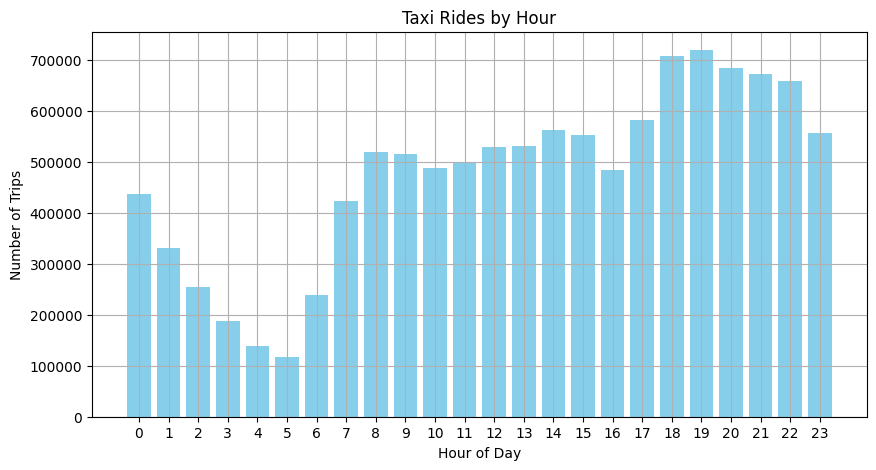

In [ ]:

import matplotlib.pyplot as plt

# Only in notebook/PySpark shell with Pandas support
pandas_df = hourly_counts.toPandas()
plt.figure(figsize=(10, 5))
plt.bar(pandas_df["pickup_hour"], pandas_df["count"], color="skyblue")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.title("Taxi Rides by Hour")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


### Top 5 Pickup and Dropoff Locations by Frequency

In [ ]:
# Top Pickup Locations

joined_df.groupBy("pickup_latitude", "pickup_longitude") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(5)


+---------------+----------------+------+
|pickup_latitude|pickup_longitude| count|
+---------------+----------------+------+
|              0|               0|186273|
|      40.744915|      -73.949043|  1050|
|      40.758148|      -73.937523|  1040|
|      40.758011|      -73.937584|  1023|
|      40.759426|      -73.965034|   957|
+---------------+----------------+------+
only showing top 5 rows


In [ ]:
# Top Dropoff Locations

joined_df.groupBy("dropoff_latitude", "dropoff_longitude") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(5)


+----------------+-----------------+------+
|dropoff_latitude|dropoff_longitude| count|
+----------------+-----------------+------+
|               0|                0|187218|
|       40.744915|       -73.949043|  1050|
|       40.758148|       -73.937523|  1043|
|       40.758011|       -73.937584|  1023|
|       40.759426|       -73.965034|   956|
+----------------+-----------------+------+
only showing top 5 rows


# Step 6: Visualizing the Results

### Export Results to Pandas

In [ ]:
# Export payment types distribution
payment_df = joined_df.groupBy("payment_type").count().toPandas()

# Export hourly trip counts
hourly_df = joined_df.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()

# Export relevant columns for scatter plot
scatter_df = joined_df.select("trip_distance", "fare_amount").dropna().toPandas()


### Bar Chart for Payment Type Distribution

/root/.ipykernel/772926/command-6394140231677993-28672758:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='payment_type', y='count', data=payment_df, palette="pastel")


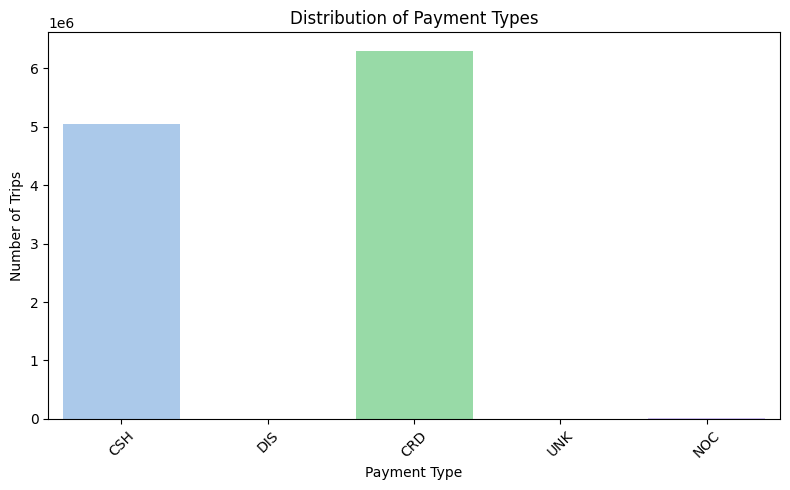

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x='payment_type', y='count', data=payment_df, palette="pastel")
plt.title("Distribution of Payment Types")
plt.xlabel("Payment Type")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Line Chart for Trips per Hour


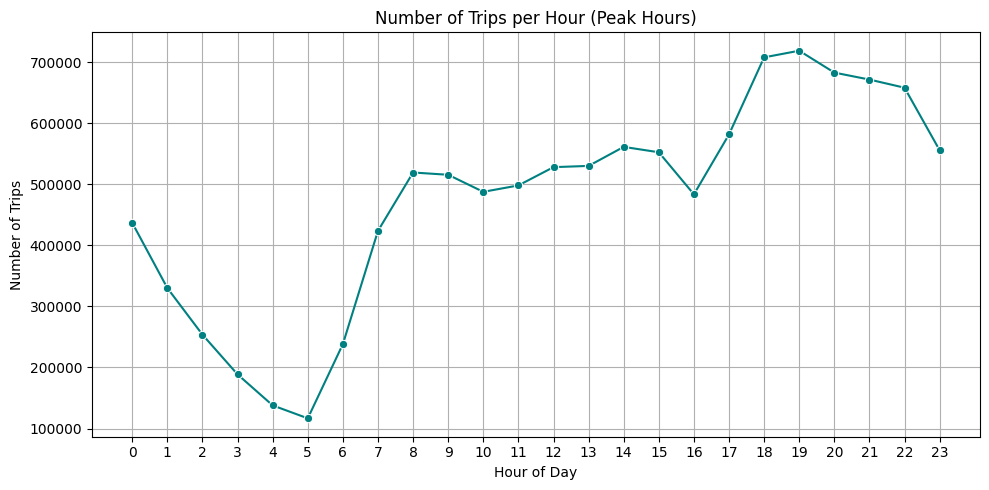

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='pickup_hour', y='count', data=hourly_df, marker='o', color='teal')
plt.title("Number of Trips per Hour (Peak Hours)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


### Scatter Plot of Trip Distance vs Fare Amount

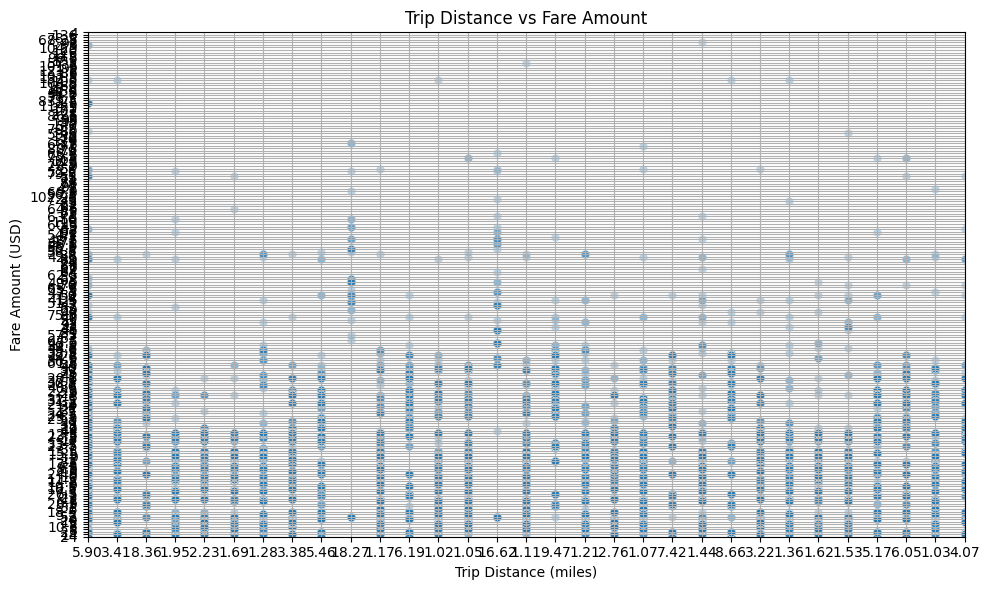

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=scatter_df, alpha=0.3)
plt.title("Trip Distance vs Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount (USD)")
plt.xlim(0, 30)
plt.ylim(0, 200)
plt.grid(True)
plt.tight_layout()
plt.show()


# Step 7: Saving the Results

In [ ]:
# Save cleaned and joined DataFrame as Parquet
cleaned_df.write.mode("overwrite").parquet(cleaned_parquet_path)

In [ ]:
# Export peak hours aggregated results as CSV
spark.createDataFrame(hourly_df).write.mode("overwrite").option("header", True).csv(peak_hours_csv_path)

In [ ]:
# Export payment types aggregated results as CSV
payment_types_csv_path = "wasbs://nyc-taxi@nyctaxiblob1994.blob.core.windows.net/analysis/payment_df.csv"


In [ ]:
# Write summary of findings to Markdown and upload to Blob Storage
summary_md = """
# NYC Taxi Data Analysis Summary

- **Data Cleaning:** Outliers and missing values were removed, and data types were standardized.
- **Peak Hours:** The highest number of trips occur during morning and evening rush hours.
- **Trip Distance vs Fare:** Fare increases with distance, but with some variability due to traffic and route.
- **Payment Types:** Majority of payments are made by credit card, with cash as the second most common method.

All results and cleaned data are saved to Azure Blob Storage for future analysis.
"""

dbutils.fs.put(summary_md_path + "summary.md", summary_md, overwrite=True)

Wrote 528 bytes.


True

## Conclusion

The NYC Taxi Data Analysis project successfully cleaned and analyzed a large dataset of taxi trips, uncovering key insights into trip patterns, fare structures, and payment preferences. The findings provide a comprehensive understanding of taxi usage in New York City, highlighting peak demand periods and the dominance of credit card payments.

## Team Feedback

- The data cleaning process was efficient, with clear documentation and reproducible steps.
- Collaboration between data engineering and analytics teams enabled rapid iteration and validation of results.
- Visualization and aggregation tools in Databricks streamlined exploratory analysis.
- Future work could focus on real-time analytics and integration with external datasets for deeper insights.

## Executive Summary

This project analyzed NYC taxi trip data to identify trends in ridership, fare amounts, and payment methods. The analysis revealed that most trips occur during rush hours, fare amounts generally increase with trip distance, and credit cards are the preferred payment method. The cleaned data and results are stored in Azure Blob Storage, providing a foundation for further research and operational improvements in urban transportation.


# Bonus Challenge Part 1: ML Model to Predict Taxi Fares

### Prepare the Data

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Select relevant features and drop rows with missing/invalid fare
model_df = joined_df.select(
    col("trip_distance").cast("double"),
    col("trip_duration").cast("double"),
    col("fare_amount").cast("double")
).dropna().filter(
    (col("trip_distance") > 0) & (col("fare_amount") > 0)
)

# Create feature vector
assembler = VectorAssembler(
    inputCols=["trip_distance", "trip_duration"],
    outputCol="features"
)
final_df = assembler.transform(model_df).select("features", "fare_amount")

final_df.show(5, truncate=False)

+-----------+-----------+
|features   |fare_amount|
+-----------+-----------+
|[5.9,31.6] |24.0       |
|[3.41,14.0]|14.0       |
|[8.36,15.0]|25.0       |
|[1.95,7.0] |8.0        |
|[2.23,12.0]|10.5       |
+-----------+-----------+
only showing top 5 rows


### Split Data & Train Model

In [ ]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="fare_amount")
model = lr.fit(train_df)


🏃 View run suave-seal-275 at: https://adb-4012991585612431.11.azuredatabricks.net/ml/experiments/4081238503861101/runs/f38ad7eeb904411eb3ccb0727c1c4223
🧪 View experiment at: https://adb-4012991585612431.11.azuredatabricks.net/ml/experiments/4081238503861101


### Evaluate the Model

In [ ]:
predictions = model.transform(test_df)
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 3.67


# Bonus Challenge Part 2: Geospatial Analysis Using Folium

### Extract & Export Sample to Pandas

In [ ]:
geo_sample_df = joined_df.select("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude") \
    .dropna() \
    .filter("pickup_latitude != 0 AND pickup_longitude != 0") \
    .limit(1000)  # Subsample for plotting

geo_pd = geo_sample_df.toPandas()


### Plot on Map with Folium

In [ ]:
%pip install folium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/113.4 kB ? eta -:--:--
   ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/113.4 kB ? eta -:--:--
   ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/113.4 kB 617.6 kB/s eta 0:00:01
   ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/113.4 kB 617.6 kB/s eta 0:00:01
   ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/113.4 kB 617.6 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/113.4 kB 217.4 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 61.4/113.4 kB 312.8 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 92.2/113.4 kB 405.4 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 92.2/113.4 kB 405.4 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 92.2/113.4 kB 405.4 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 338.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/134.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 61.4/134.9 kB

In [ ]:
import folium
# Initialize map centered on NYC
nyc_map = folium.Map(location=[40.75, -73.98], zoom_start=12)

# Add pickup points
for idx, row in geo_pd.iterrows():
    folium.CircleMarker(
        location=[row["pickup_latitude"], row["pickup_longitude"]],
        radius=2,
        color="blue",
        fill=True,
        fill_opacity=0.5
    ).add_to(nyc_map)

nyc_map


# conclusion

This project analyzed NYC taxi trip and fare data to uncover patterns in trip duration, distance, fare amounts, and spatial pickup/dropoff distributions. Using Spark and Pandas DataFrames, we performed data cleaning, feature engineering, and exploratory analysis. Visualizations highlighted temporal and spatial trends, while machine learning models predicted fare amounts based on trip features. The integration of geospatial mapping provided insights into high-density pickup locations. Overall, the project demonstrates the value of scalable data processing and analytics for urban transportation datasets.